https://ai.gopubby.com/uplift-modeling-advanced-customer-targeting-with-causal-machine-learning-985497065e78

In [1]:
%pip install scikit-uplift

Note: you may need to restart the kernel to use updated packages.


In [43]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from causalml.inference.tree import UpliftRandomForestClassifier, uplift_tree_plot
from causalml.metrics import auuc_score, plot_gain
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_criteo


# Ensure the required libraries are installed
print(importlib.metadata.version('causalml'))

0.15.1


In [25]:
X, y, treatment = fetch_criteo(target_col="conversion", treatment_col="treatment", return_X_y_t=True)

df = X.copy()
df["conversion"] = y.astype("int64")
df["treatment"] = treatment.astype("object").replace({0: "control", 1: "treatment"})

df.head()


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,conversion,treatment
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment


In [34]:
df_0 = df[df.conversion == 0].sample(int(df.conversion.value_counts()[0]*0.01))

df = pd.concat([df_0, df[df.conversion == 1]], axis=0)
print(df_0.shape, df[df.conversion == 1].shape, df.shape)

(139388, 14) (40774, 14) (180162, 14)


In [35]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 180162


In [36]:
df['treatment'].value_counts(normalize = True)

treatment
treatment    0.861619
control      0.138381
Name: proportion, dtype: float64

In [37]:
df['conversion'].value_counts(normalize = True)

conversion
0    0.773681
1    0.226319
Name: proportion, dtype: float64

### Training the Uplift Model

In [56]:
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    df.drop(columns=["conversion", "treatment"]), df["conversion"], df["treatment"], test_size=0.3, random_state=42
)

# Train Uplift Random Forest model
uplift_rf = UpliftRandomForestClassifier(control_name="control")
uplift_rf.fit(X_train.values, treatment=treatment_train.values, y=y_train.values)

# Predict uplift using the trained model
y_pred = uplift_rf.predict(X_test)


### Visualisation

In [57]:
uplift_tree = uplift_rf.uplift_forest[0]

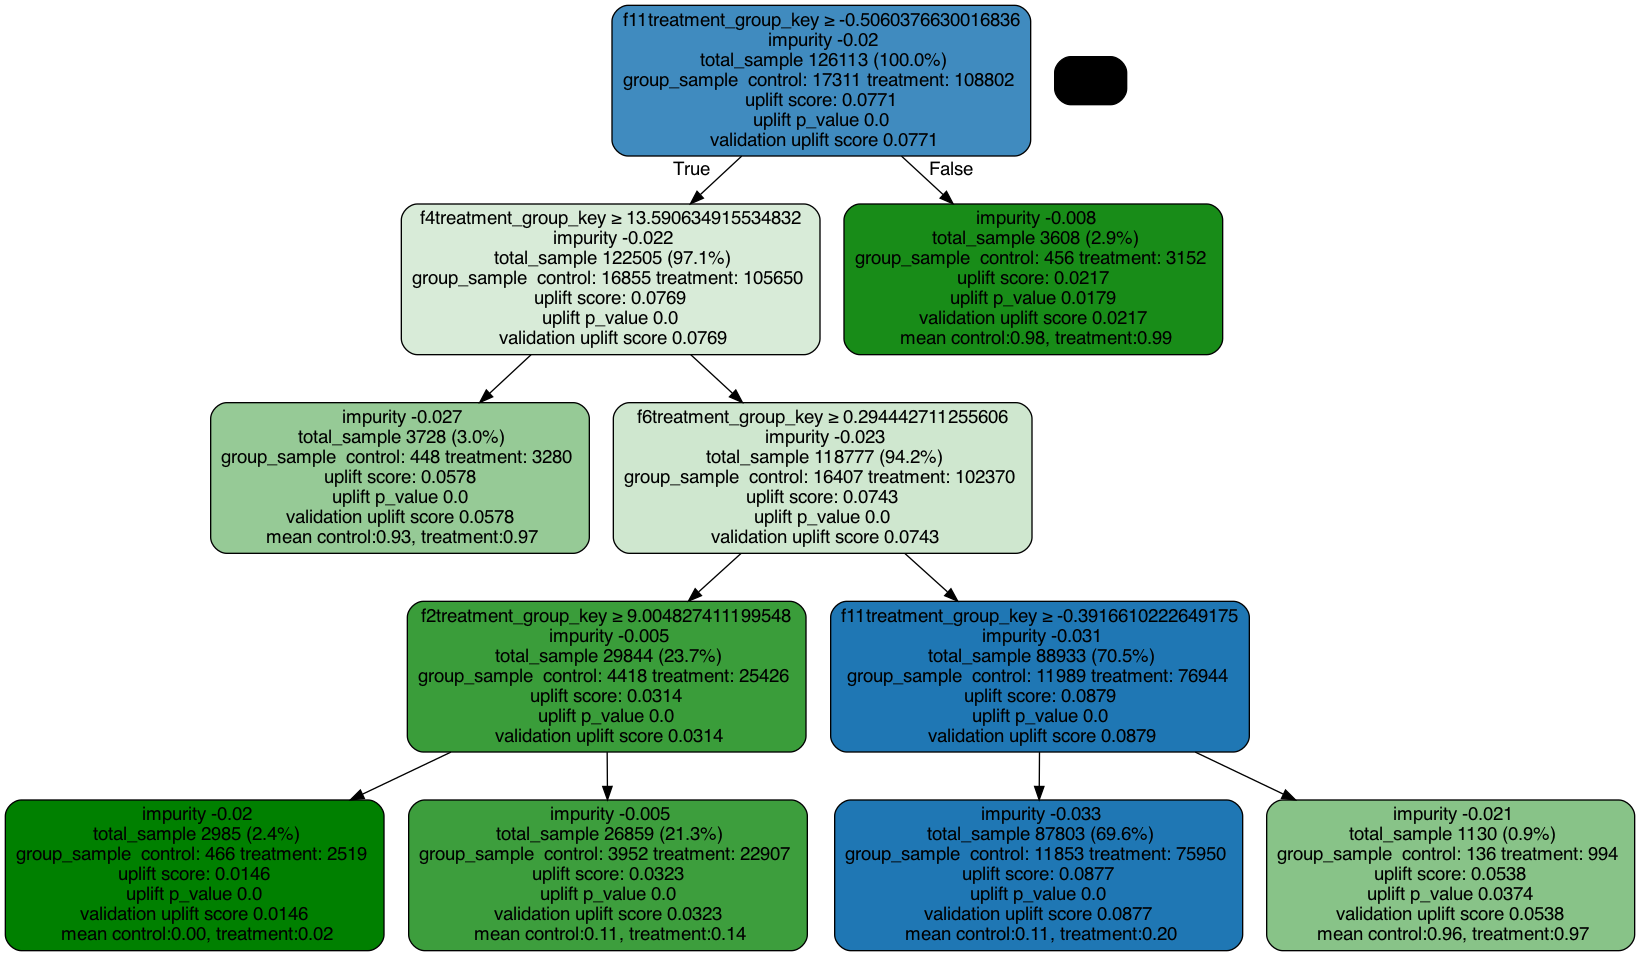

In [58]:
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, X_train.columns)
Image(graph.create_png())

<Axes: >

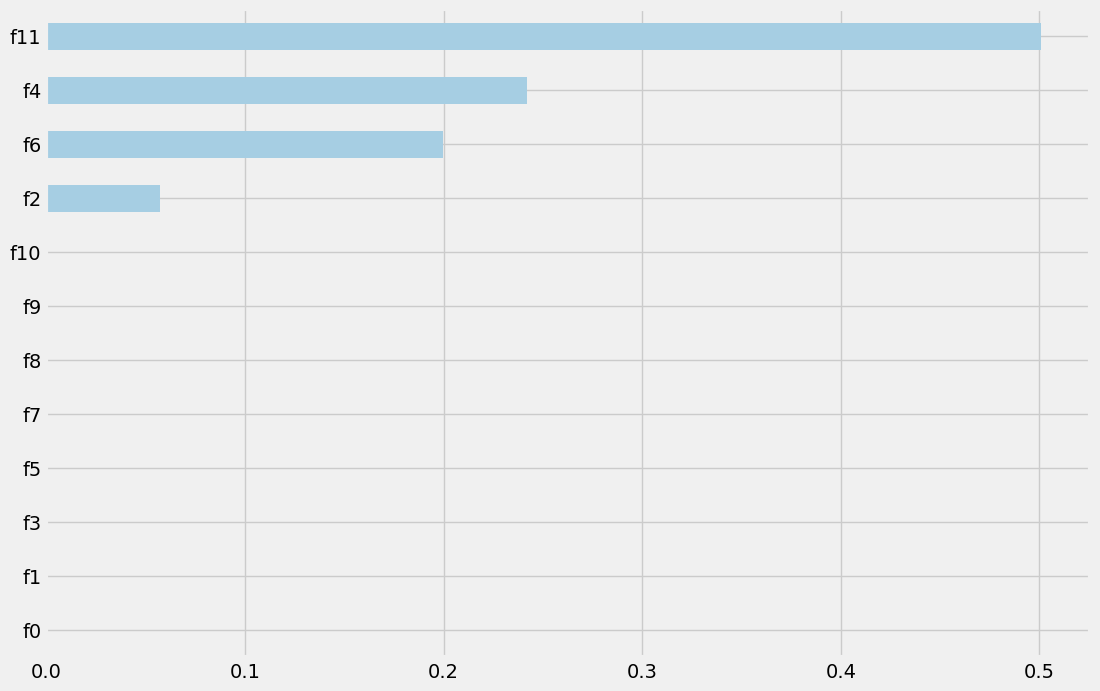

In [59]:
pd.Series(uplift_tree.feature_importances_, index = X_train.columns).sort_values().plot(kind='barh', figsize=(12,8))

### Evaluation

In [60]:
uplift_results = pd.DataFrame(y_pred, columns=uplift_rf.classes_[1:])

best_treatment = np.where(uplift_results["treatment"] < 0, "control", "treatment")

auuc_metrics = uplift_results.assign(
    is_treated=(treatment_test.values != "control").astype(int),
    conversion=pd.concat([X_test, y_test, treatment_test], axis=1)["conversion"].values,
    uplift=uplift_results.max(axis=1),
).drop(columns=list(uplift_rf.classes_[1:]))


### Total Cumulative Gain

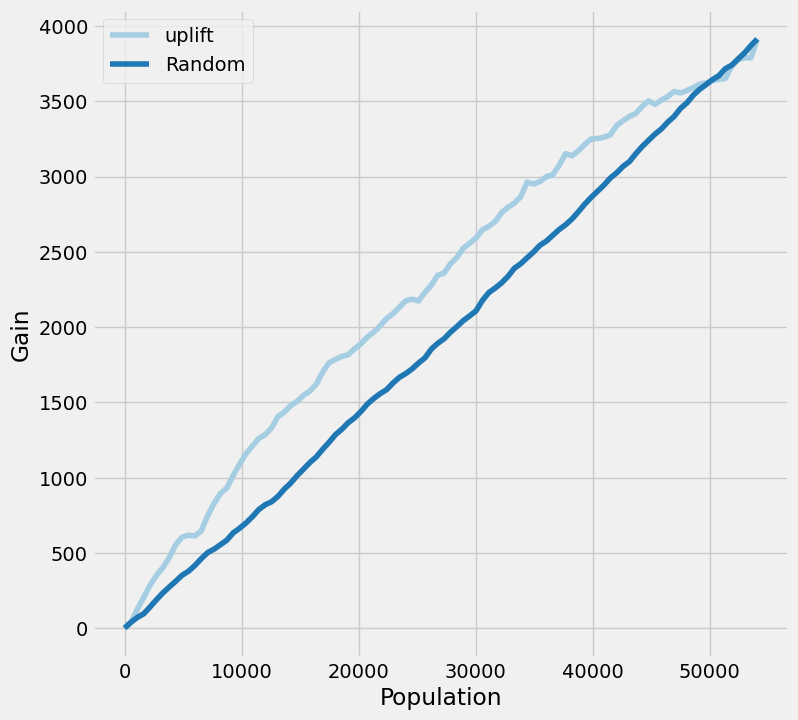

In [61]:
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

The Uplift Curve illustrates the Total Cumulative Gain, showing how effectively the model targets users likely to convert upon seeing the ads

### AUUC (Area Under the Uplift Curve) Score

In [62]:

score = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(score)

uplift    0.577620
Random    0.493079
dtype: float64


The AUUC score evaluates uplift modeling performance, similar to AUC (Area Under the ROC Curve). A score close to 1 indicates strong performance, while a score near 0.5 suggests no better performance than random guessing

### Extracting Targeted Users

In [63]:
uplift_results['user_id'] = X_test.index
uplift_results.rename(columns={'treatment': 'uplift'}, inplace=True)
uplift_results_sorted = uplift_results.sort_values(by='uplift', ascending=False).reset_index(drop=True)

# Print the customer list
print("Customer List Sorted by Uplift:")
display(uplift_results_sorted[['user_id', 'uplift']].head(10))

Customer List Sorted by Uplift:


,user_id,uplift
0,1315786,0.088363
1,213988,0.088363
2,5100705,0.088363
3,2564164,0.088363
4,6417935,0.088363
5,3634482,0.088363
6,5372228,0.088363
7,1626551,0.088363
8,11252869,0.088363
9,4807580,0.088363


In [64]:
uplift_results_sorted["rank"] = uplift_results_sorted["uplift"].rank(method="first", ascending=False)
uplift_results_sorted["decile"] = pd.qcut(uplift_results_sorted["rank"], 10, labels=False)

decile_labels = [
    "top 10%",
    "top 10%-20%",
    "top 20%-30%",
    "top 30%-40%",
    "top 40%-50%",
    "top 50%-60%",
    "top 60%-70%",
    "top 70%-80%",
    "top 80%-90%",
    "bottom 10%",
]

column_order = ["user_id", "uplift", "rank", "decile", "decile_label"]
uplift_results_sorted["decile_label"] = uplift_results_sorted["decile"].map(lambda x: decile_labels[x])
uplift_results_sorted[column_order].head(10)


,user_id,uplift,rank,decile,decile_label
0,1315786,0.088363,1.0,0,top 10%
1,213988,0.088363,2.0,0,top 10%
2,5100705,0.088363,3.0,0,top 10%
3,2564164,0.088363,4.0,0,top 10%
4,6417935,0.088363,5.0,0,top 10%
5,3634482,0.088363,6.0,0,top 10%
6,5372228,0.088363,7.0,0,top 10%
7,1626551,0.088363,8.0,0,top 10%
8,11252869,0.088363,9.0,0,top 10%
9,4807580,0.088363,10.0,0,top 10%
